# Práctica 9

### TDM - Máster en IoT - Rafael Caballero

En una compañía que se dedican al transporte de vino de alta calidad están preocupados porque en ocasiones algunos operarios voltean las cajas, lo que afecta a la calidad del producto.

<div>
<img src="https://raw.githubusercontent.com/RafaelCaballero/tdm/master/images/12-bottle-wooden-wine-box-2-1500x1500.jpg" width="100"/>
</div>

Por ello deciden instalar en la tapa de algunas cajas unos sensores que indican la orientación x,y,z, así como la luz (l), la temperatura (t) y la  humedad (h). Se han hecho experimentos en las naves de carga, apuntando los datos de los sensores en diversas posiciones. En el conjunto de datos esto corresponde con la columna *label*.  Así, label=1 indica que la caja está correcta, label=2 que está invertida, y los valores 3,4,5 son distintas variantes de caja puesta por el lateral. 

Vamos a utilizar Spark para decidir en qué condiciones debe saltar una alarma indicando en cuál de las 5 posiciones está la caja.


Como siempre, empezamos cargando las librerías, Spark y el conjunto inicial de datos.

In [5]:
import sys
# comprobar la librería
try:
    import findspark
    print("Spark está en el sistema!")
except ImportError as e:
    !{sys.executable} -m pip install --upgrade --user findspark
    

try:
    import pyspark
    print("Pyspark encontrado")
except ImportError as e:
    !{sys.executable} -m pip install --upgrade --user pyspark

try:
    import yellowbrick
    print("KElbowVisualizer encontrado")
except ImportError as e:
    !{sys.executable} -m pip install --upgrade --user yellowbrick
    
    

Spark está en el sistema!
Pyspark encontrado
KElbowVisualizer encontrado


Este es el código con los paths, en el laboratorio se puede saltar y en algunos casos habrá que cambiarlo

In [6]:

# descargar la carpeta copiar la carpeta spark en c:\hlocal\tdm
import os
# cambiamos las variables del sistema
spark = 'C:/hlocal/tdm/spark/spark-3.0.1-bin-hadoop3.2/spark-3.0.1-bin-hadoop3.2'

if not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :
    print("Error, la carpeta en 'spark' debe contener los directorios bin y jars ")
else:    
    # en el path se añade
    #path = os.environ.get('PATH') 
    #path = path+ ';'+spark+'\\bin;'
    #os.environ['PATH'] = path
    os.environ['SPARK_HOME']= spark 
    os.environ['HADOOP_HOME']= spark 
    os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
    os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

    # si da problema quizás haya que poner java_home a la localización de java 8
    #os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
    #os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+spark
    print("Hecho")

Hecho


In [7]:
  
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
print("Preparado!!")

Preparado!!


In [8]:
# cargamos los datos
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

path = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/datoscajas.csv"

df = spark.createDataFrame(pd.read_csv(path))
print("Número de filas:", df.count())
dfp = df.toPandas()
dfp

Número de filas: 1875


,x,y,z,l,t,h,label
0,1.00,0.01,-1.39,648.0,23.50,48.0,5
1,1.00,0.04,-1.36,632.0,23.45,47.0,5
2,0.00,0.04,-2.04,73.0,20.90,26.0,2
3,1.00,0.01,-1.31,640.0,23.40,48.0,5
4,1.02,-0.00,-1.38,639.5,23.50,48.0,5
...,...,...,...,...,...,...,...
1870,0.02,-0.01,-2.02,76.5,23.90,46.0,2
1871,1.02,0.04,-0.86,743.0,18.60,26.0,5
1872,1.00,0.04,-1.36,629.0,23.40,48.0,5
1873,1.02,-0.05,-0.98,69.0,24.60,43.0,3






Aunque en principio se pensó en un sistema de clasificación supervisada para detectar la posición de la caja, se ha considerado que almacenar ese sistema junto con los sensores es demasiado caro. Se ha decidido probar con un sistema de clustering que determine los valores "centrales" de cada etiqueta, de forma que sea fácil de comprobar qué centro es el más cercano a los valores que transmiten los sensores y así determinar la posición.



Los valores de las columnas x,y,z,  parece que distribuyen bastante bien las etiquetas, salvo por los casos label==3 y label==5

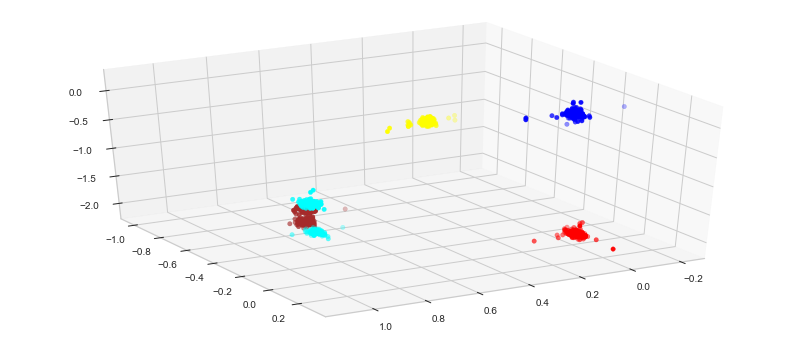

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure(figsize=(14,6))
ax = fig.gca(projection='3d')
ax.view_init(35, 60) # rotamos la figura
p = ax.scatter(dfp[dfp.label==1].x, dfp[dfp.label==1].y, dfp[dfp.label==1].z,color="blue")
p = ax.scatter(dfp[dfp.label==2].x, dfp[dfp.label==2].y, dfp[dfp.label==2].z,color="red")
p = ax.scatter(dfp[dfp.label==3].x, dfp[dfp.label==3].y, dfp[dfp.label==3].z,color="brown")
p = ax.scatter(dfp[dfp.label==4].x, dfp[dfp.label==4].y, dfp[dfp.label==4].z,color="yellow")
p = ax.scatter(dfp[dfp.label==5].x, dfp[dfp.label==5].y, dfp[dfp.label==5].z,color="cyan")
plt.show()


### Pregunta 1 [1 punto]

Lo primero, habría que elegir el k óptimo, así como las columnas que se quieren utilizar. Probar a modificar el array *feat_cols* del siguiente código, jugando con las columnas x,y,z,l,t,h buscando elegir un conjunto de columnas que: 

- Incluya al menos "x","y","z"
- Si puede ser se alcance k=5
- El codo quede lo más marcado posible

Nota 1: en este caso lo hacemos a ojo, probando distintos subconjuntos de atributos con el método del codo, hasta obtener el mayor k

Nota 2: No tocar el resto de código, solo feat_cols

Nota 3: se puede usar algún escalador si ayuda, pero no es obligatorio

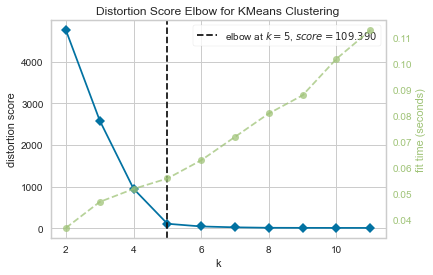

In [62]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

##### aquí es dónde hay que tocar
feat_cols = ["x","y","z","l"]  # probar a añadir uno o varios de entre l,t,h para lograr k=5 y codo muy marcado
#####
df2 = df.select(feat_cols).toPandas()

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(StandardScaler().fit_transform(df2[feat_cols]))      # Fit the data to the visualizer
visualizer.show()

### Pregunta 2 [3 puntos]
Escribir el código en Spark para formar estos clusters con estos features; el resultado final tiene que llamarse *kpredictions* y el modelo *kmodel*. Debe utilizarse un StandardScaler y el método KMeans aplicado a las columnas escaladas.

Se valorará hacerlo con un pipeline

In [71]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans  


    
## K-means 
# creamos el vector "features"
#feat_cols = []
feat_cols = ["x","y","z","l"]
assembler = VectorAssembler(
    inputCols=feat_cols,
    outputCol="features",
    handleInvalid='skip')
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol("scaledFeatures")

pipeline = Pipeline(stages=[assembler, scaler, kmeans])

kmodel = pipeline.fit(df)
kpredictions = kmodel.transform(df)


In [72]:
kpredictions.toPandas()

,x,y,z,l,t,h,label,features,scaledFeatures,prediction
0,1.00,0.01,-1.39,648.0,23.50,48.0,5,"[1.0, 0.01, -1.39, 648.0]","[2.0218386699334783, 0.02522970314473798, -2.1...",4
1,1.00,0.04,-1.36,632.0,23.45,47.0,5,"[1.0, 0.04, -1.36, 632.0]","[2.0218386699334783, 0.10091881257895192, -2.0...",4
2,0.00,0.04,-2.04,73.0,20.90,26.0,2,"[0.0, 0.04, -2.04, 73.0]","[0.0, 0.10091881257895192, -3.108529018619658,...",0
3,1.00,0.01,-1.31,640.0,23.40,48.0,5,"[1.0, 0.01, -1.31, 640.0]","[2.0218386699334783, 0.02522970314473798, -1.9...",4
4,1.02,-0.00,-1.38,639.5,23.50,48.0,5,"[1.02, 0.0, -1.38, 639.5]","[2.062275443332148, 0.0, -2.1028284537721214, ...",4
...,...,...,...,...,...,...,...,...,...,...
1870,0.02,-0.01,-2.02,76.5,23.90,46.0,2,"[0.02, -0.01, -2.02, 76.5]","[0.040436773398669565, -0.02522970314473798, -...",0
1871,1.02,0.04,-0.86,743.0,18.60,26.0,5,"[1.02, 0.04, -0.86, 743.0]","[2.062275443332148, 0.10091881257895192, -1.31...",4
1872,1.00,0.04,-1.36,629.0,23.40,48.0,5,"[1.0, 0.04, -1.36, 629.0]","[2.0218386699334783, 0.10091881257895192, -2.0...",4
1873,1.02,-0.05,-0.98,69.0,24.60,43.0,3,"[1.02, -0.05, -0.98, 69.0]","[2.062275443332148, -0.1261485157236899, -1.49...",3


### Pregunta 3 [2 puntos]

Las clases predichas van de 0 a 4 inclusive. Podemos ver cuántos elementos se han predicho de cada clase con el siguiente código:

In [73]:
for j in range(5):
    dfj = kpredictions.filter(kpredictions.prediction==j)
    nj = dfj.count()
    print("Clase predicha",j," elementos: ",nj)

Clase predicha 0  elementos:  375
Clase predicha 1  elementos:  375
Clase predicha 2  elementos:  374
Clase predicha 3  elementos:  376
Clase predicha 4  elementos:  375


Vamos a medir lo bueno son estas predicciones para obtener cada label. Para ello debemos decidir a qué label hacemos corresponder cada prediction. 

Tomando como referencia el código anterior, completar el siguiente que muestra, para cada label, cúantos elementos de ese label quedan recogidos por cada clase predicha


In [74]:
# para cada etiqueta
for i in range(1,6):
    # dfi = filtrar kpredictions para quedarse con los elementos con label i
    dfi = kpredictions.filter(kpredictions.label==i)
    # ni = contar el número de elementos de dfi
    ni = dfi.count()
    print("label=",i," Elementos ",ni)
    # ahora vemos cómo se reparten estos elementos por las predicciones
    for j in range(5):
        # dfij = filtrar dfi para quedarse los que tengan prediction j
        dfij = dfi.filter(dfi.prediction==j)
        # nij = número de elementos de dfij
        nij = dfij.count()
        print(" Predicción ",j," ",nij, "(",round(nij*100/ni,2),"%)")

label= 1  Elementos  375
 Predicción  0   0 ( 0.0 %)
 Predicción  1   375 ( 100.0 %)
 Predicción  2   0 ( 0.0 %)
 Predicción  3   0 ( 0.0 %)
 Predicción  4   0 ( 0.0 %)
label= 2  Elementos  375
 Predicción  0   375 ( 100.0 %)
 Predicción  1   0 ( 0.0 %)
 Predicción  2   0 ( 0.0 %)
 Predicción  3   0 ( 0.0 %)
 Predicción  4   0 ( 0.0 %)
label= 3  Elementos  376
 Predicción  0   0 ( 0.0 %)
 Predicción  1   0 ( 0.0 %)
 Predicción  2   0 ( 0.0 %)
 Predicción  3   376 ( 100.0 %)
 Predicción  4   0 ( 0.0 %)
label= 4  Elementos  374
 Predicción  0   0 ( 0.0 %)
 Predicción  1   0 ( 0.0 %)
 Predicción  2   374 ( 100.0 %)
 Predicción  3   0 ( 0.0 %)
 Predicción  4   0 ( 0.0 %)
label= 5  Elementos  375
 Predicción  0   0 ( 0.0 %)
 Predicción  1   0 ( 0.0 %)
 Predicción  2   0 ( 0.0 %)
 Predicción  3   0 ( 0.0 %)
 Predicción  4   375 ( 100.0 %)


### Pregunta 4 [2 puntos]

Parece que lo hemos logrado, pero tenemos que hacer un último esfuezo escribiendo una función *caja* que reciba como parámetros:

- El modelo desarrollado
- x,y,z,l,t,h

y devuelva un valor de 1 a 5 indicando el movimiento más probable.  Para ello, *caja* deberá:

- Convertir x,y,z,l,t,h en un dataframe de reales de una sola fila con nombres de columnas "x","y","z","l","t","h" ver esta [página](https://sparkbyexamples.com/pyspark/pyspark-create-dataframe-from-list/)
- Aplicar el modelo al nuevo dataframe
- Extraer el valor *prediction* y convertir la clase predicha en un valor de 1 a 5 según la correspondencia que se ha visto en el apartado anterior (se puede hacer con ifs o como se quiera)

In [81]:
def caja(kmodel,  x,y,z,l,t,h ):
    columns = ["x", "y", "z", "l", "t", "h"]
    datas = [(x,y,z,l,t,h)]
    dataframe = spark.createDataFrame(data = datas, schema = columns)
    prediction = kmodel.transform(dataframe)
    datos = prediction.toPandas()
    valor = datos.iloc[0]['prediction']
    if valor == 0:
        return 2;
    elif valor == 1:
        return 1;
    elif valor == 2:
        return 4;
    elif valor == 3:
        return 3;
    elif valor == 4:
        return 5;
    

Para probar:

In [82]:
a = caja(kmodel,-0.01,-0.99,-1.11,335.5,23.8,46.0)
print("Debe salir 4 y sale ",a)

b = caja(kmodel,0,0,0,746,23.8,46.0)
print("Debe salir 1 y sale ",b)

Debe salir 4 y sale  4
Debe salir 1 y sale  1


### Pregunta 5 (2 puntos)

Ahora queremos ver si según estos datos sería posible ahorrarnos algún sensor. Para ello

a) [1] Mostrar la correlación entre cada par de columnas de df

In [114]:
conti = 0
contj = 0
maximo = 0
index = [0, 0]
matrix = np.zeros((7,7))
for i in df.columns:
    
    for j in df.columns:
        valor = df.corr(i,j)
        matrix[conti, contj] = valor
        if valor > maximo and valor != 1.0:
            maximo = df.corr(i,j)
            index = (i, j)
        contj = contj + 1
    
    conti = conti + 1
    contj = 0

print(matrix)
print("En la matriz de correlación se ha encontrado el maximo", maximo, "en", index)

[[ 1.00000000e+00  3.95067651e-01 -4.23181021e-02 -9.59694033e-03
  -7.34433196e-02 -2.36616501e-02  5.72412128e-01]
 [ 3.95067651e-01  1.00000000e+00 -1.60061525e-02  5.88866830e-02
   6.80855724e-02 -5.16408147e-04 -3.42152136e-01]
 [-4.23181021e-02 -1.60061525e-02  1.00000000e+00  7.28639579e-01
  -1.11558954e-01 -2.41411325e-03 -2.80599335e-01]
 [-9.59694033e-03  5.88866830e-02  7.28639579e-01  1.00000000e+00
  -1.57979055e-01  7.61051963e-02  7.73346117e-02]
 [-7.34433196e-02  6.80855724e-02 -1.11558954e-01 -1.57979055e-01
   1.00000000e+00  9.22802672e-01 -1.60122998e-01]
 [-2.36616501e-02 -5.16408147e-04 -2.41411325e-03  7.61051963e-02
   9.22802672e-01  1.00000000e+00  7.03889833e-03]
 [ 5.72412128e-01 -3.42152136e-01 -2.80599335e-01  7.73346117e-02
  -1.60122998e-01  7.03889833e-03  1.00000000e+00]]
En la matriz de correlación se ha encontrado el maximo 0.9228026724170721 en ('h', 't')


b) [1] Para la pareja de columnas que muestre mayor correlación, buscar un modelo de regresión lineal, que permita decidir el valor de una de las dos a partir de la otra.  Dividir el conjunto df al 50% entre train y test y mostrar el R^2 y el RMSE obtenidos. El modelo se hará combinando en un pipeline un vectorassembler y un LinearRegression.


Nota: No hace falta escalar

In [132]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

datos_aux = df.select('h', 't')

datos_aux2 = datos_aux.withColumnRenamed("h", "label")

vectorcols = ['t']
assembler = VectorAssembler(
    inputCols=vectorcols,
    outputCol='features')

splits = datos_aux2.randomSplit([0.5, 0.5])

train_data = splits[0]
test_data = splits[1]

pipeline = Pipeline(stages=[assembler, lr])

lrModel = pipeline.fit(train_data)
lr_predictions = lrModel.transform(test_data)



metrics=["r2", "rmse"]
evaluators = [(m,RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName=m)) for m in metrics]

errors = [ (name, eval.evaluate(lr_predictions)) for name,eval in evaluators]
print(errors)

[('r2', 0.8502289983347421), ('rmse', 3.9877400033720476)]
